In [1]:
import cv2
import json
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

In [2]:
json_filename = '../visualization/annotations/VAN0003-LK-33-2-PAS_FFPE_glom_annotations.json'
read_file = open(json_filename, "r") 
data = json.load(read_file)
data[0]

{'type': 'Feature',
 'id': 'PathAnnotationObject',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[2553, 12397],
    [2495, 12449],
    [2491, 12528],
    [2505, 12606],
    [2552, 12663],
    [2583, 12673],
    [2647, 12663],
    [2725, 12612],
    [2731, 12578],
    [2642, 12419],
    [2597, 12397],
    [2553, 12397]]]},
 'properties': {'classification': {'name': 'glomerulus', 'colorRGB': -3140401},
  'isLocked': True,
  'measurements': []}}

In [3]:
polys = []
for index in range(data.__len__()):
    geom = np.array(data[index]['geometry']['coordinates'])
    polys.append(geom)

# the shape of the image, h * w
shape = (18484, 13013)

# Ref code for converting polygon vector into pixel masks

## Method 1

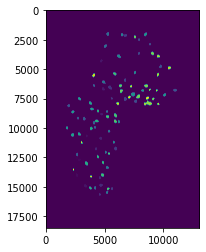

In [4]:
mask_1 = np.zeros(shape)
for i in range(len(polys)):
    cv2.fillPoly(mask_1, polys[i], i+1)

plt.imshow(mask_1)

# Ref code for converting polygon vector into pixel masks

## Method 2

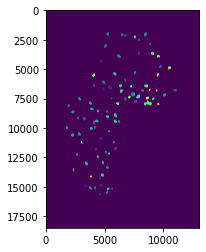

In [5]:
Image.MAX_IMAGE_PIXELS = None
img = Image.new('L', (shape[1], shape[0]), 0)  # (w, h)
for i in range(len(polys)):
    poly = polys[i]
    ImageDraw.Draw(img).polygon(tuple(map(tuple, poly[0])), outline=i + 1, fill=i + 1) 

mask_2 = np.array(img)
plt.imshow(mask_2)

# Run-length encoding

In order to reduce the submission file size, teams must submit segmentation results using run-length encoding on the pixel values.  That is, instead of submitting an exhaustive list of indices for your segmentation, you will submit pairs of values that contain a start position and a run length. E.g. '0 3' implies starting at pixel 0 and running a total of 3 pixels (0,1,2).

The competition format requires a space delimited list of pairs. For example, '0 3 10 5' implies pixels 0,1,2, and 10,11,12,13,14 are to be included in the mask. The metric checks that the pairs are sorted, positive, and the decoded pixel values are not duplicated. The pixels are numbered from top to bottom, then left to right: 0 is pixel (0,0), 1 is pixel (1,0), and 2 is pixel (2,0) etc., see the sample image below.

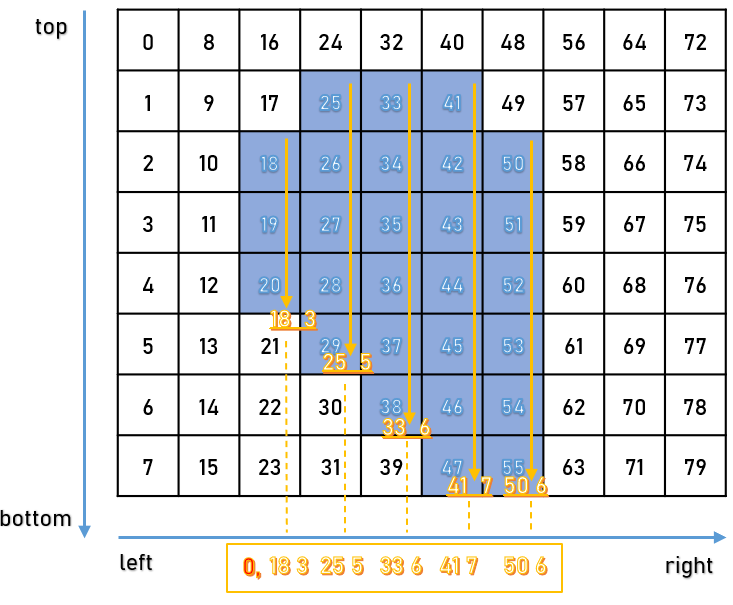

For example:

The sample image has 10 rows and 8 columns and the pixels are numbered from 0 to 79 based on the sequence from top to bottom and then left to right. The shaded area is the mask and the encoding of the mask starts from the 18th to the following three pixels (18 3), then from the 25th to the next five pixels (25 5), and etc. Finally the line of the mask encoding of “glom 0” is:

0, 18 3 25 5 33 6 41 7 50 6

There should be 20 csv files submitted (for 11 fresh frozen and 9 FFPE PAS kidney images). Each file should have the same file name with the image file but ends with “.csv”. For example, if the image file is hackathon_sample.tiff, the result csv file should be hackathon_sample.csv. Each csv file should contain a header and have the following format. Each line is a glomerulus and the line starts with the unique id (starts from 0) of the glomeruli.

In [6]:
mask_1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
range(len(polys))

range(0, 96)

## method 1

In [8]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), non 0 - mask, 0 - background
    Returns run length as list
    '''
    run_lengths = []
    for i in range(len(polys)):
        run_lengths.append([])
    current = 0
    count = 0
    start = 0
    flat = x.T.flatten()
    for i in range(len(flat)):
        dot = flat[i]
        if dot == 0:
            if current == 0:
                continue
            else:
                run_lengths[current-1].extend([start, count])
                current = 0
                count = 0
                start = 0
        else:
            if dot == current:
                count += 1
            elif count != 0:
                run_lengths[current-1].extend([start, count])
                current = 0
                count = 0
                start = 0
            else:
                start = i
                current = dot
                count += 1
    return run_lengths

In [9]:
encoding = rle_encoding(mask_1.astype('uint8'))

## method 2

In [10]:
def rle_encoding_2(x):
    '''
    x: numpy array of shape (height, width), non 0 - mask, 0 - background
    Returns run length as list
    '''
    run_lengths = []
    for i in range(len(polys)):
        run_lengths.append([])
        dots = np.where(x.T.flatten()==i+1)[0] # .T sets Fortran order down-then-right
        prev = -2
        for b in dots:
            if (b>prev+1): run_lengths[-1].extend((b, 0))
            run_lengths[-1][-1] += 1
            prev = b
    return run_lengths

In [11]:
encoding_2 = rle_encoding_2(mask_1.astype('uint8'))

In [12]:
encoding[0]

[46056163,
 12,
 46074627,
 38,
 46093091,
 63,
 46111555,
 89,
 46130029,
 105,
 46148512,
 111,
 46166995,
 118,
 46185478,
 124,
 46203961,
 131,
 46222445,
 136,
 46240928,
 143,
 46259411,
 150,
 46277894,
 156,
 46296377,
 163,
 46314860,
 167,
 46333343,
 169,
 46351826,
 172,
 46370309,
 174,
 46388792,
 176,
 46407276,
 177,
 46425759,
 179,
 46444242,
 182,
 46462725,
 184,
 46481208,
 186,
 46499691,
 188,
 46518174,
 190,
 46536657,
 193,
 46555140,
 195,
 46573623,
 197,
 46592107,
 198,
 46610590,
 201,
 46629073,
 203,
 46647556,
 205,
 46666039,
 207,
 46684522,
 209,
 46703005,
 212,
 46721488,
 214,
 46739971,
 216,
 46758455,
 217,
 46776938,
 219,
 46795421,
 222,
 46813904,
 224,
 46832387,
 226,
 46850870,
 228,
 46869353,
 230,
 46887836,
 233,
 46906319,
 235,
 46924802,
 237,
 46943286,
 238,
 46961769,
 241,
 46980252,
 243,
 46998735,
 245,
 47017218,
 247,
 47035701,
 249,
 47054184,
 252,
 47072667,
 254,
 47091150,
 256,
 47109633,
 258,
 47128117,
 259,
 

In [13]:
encoding_2[0]

[46056163,
 12,
 46074627,
 38,
 46093091,
 63,
 46111555,
 89,
 46130029,
 105,
 46148512,
 111,
 46166995,
 118,
 46185478,
 124,
 46203961,
 131,
 46222445,
 136,
 46240928,
 143,
 46259411,
 150,
 46277894,
 156,
 46296377,
 163,
 46314860,
 167,
 46333343,
 169,
 46351826,
 172,
 46370309,
 174,
 46388792,
 176,
 46407276,
 177,
 46425759,
 179,
 46444242,
 182,
 46462725,
 184,
 46481208,
 186,
 46499691,
 188,
 46518174,
 190,
 46536657,
 193,
 46555140,
 195,
 46573623,
 197,
 46592107,
 198,
 46610590,
 201,
 46629073,
 203,
 46647556,
 205,
 46666039,
 207,
 46684522,
 209,
 46703005,
 212,
 46721488,
 214,
 46739971,
 216,
 46758455,
 217,
 46776938,
 219,
 46795421,
 222,
 46813904,
 224,
 46832387,
 226,
 46850870,
 228,
 46869353,
 230,
 46887836,
 233,
 46906319,
 235,
 46924802,
 237,
 46943286,
 238,
 46961769,
 241,
 46980252,
 243,
 46998735,
 245,
 47017218,
 247,
 47035701,
 249,
 47054184,
 252,
 47072667,
 254,
 47091150,
 256,
 47109633,
 258,
 47128117,
 259,
 

# Validation of the encoding

## restore the image from the encoding

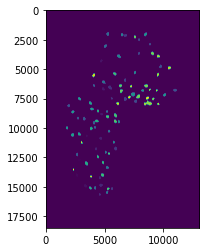

In [14]:
# validation

generated_1d_mask = np.zeros((shape[1]*shape[0]))

for i in range(len(encoding_2)):
    for j in range(len(encoding_2[i]) // 2):
            generated_1d_mask[encoding[i][j * 2]:encoding[i][j * 2]+encoding[i][j * 2+1]] = i
        
generated_mask = generated_1d_mask.reshape((shape[1], shape[0])).T
plt.imshow(generated_mask)

# Save the encoding to csv file

In [15]:
file = open('test.csv', 'w', newline ='') 
  
with file: 
    # identifying header   
    header = ['glom', 'pixels'] 
    writer = csv.DictWriter(file, fieldnames = header) 
      
    # writing data row-wise into the csv file 
    writer.writeheader()
    for i in range(len(encoding)):
        writer.writerow({'glom' : i,  
                         'pixels': ' '.join([str(item) for item in encoding[i]]), 
                        }) 

In [16]:
with open('test.csv', newline='') as testfile:
    print(testfile.read())

glom,pixels
0,46056163 12 46074627 38 46093091 63 46111555 89 46130029 105 46148512 111 46166995 118 46185478 124 46203961 131 46222445 136 46240928 143 46259411 150 46277894 156 46296377 163 46314860 167 46333343 169 46351826 172 46370309 174 46388792 176 46407276 177 46425759 179 46444242 182 46462725 184 46481208 186 46499691 188 46518174 190 46536657 193 46555140 195 46573623 197 46592107 198 46610590 201 46629073 203 46647556 205 46666039 207 46684522 209 46703005 212 46721488 214 46739971 216 46758455 217 46776938 219 46795421 222 46813904 224 46832387 226 46850870 228 46869353 230 46887836 233 46906319 235 46924802 237 46943286 238 46961769 241 46980252 243 46998735 245 47017218 247 47035701 249 47054184 252 47072667 254 47091150 256 47109633 258 47128117 259 47146600 262 47165083 264 47183566 266 47202049 267 47220533 268 47239017 268 47257501 268 47275985 269 47294469 269 47312953 269 47331437 270 47349921 270 47368405 270 47386889 271 47405373 271 47423857 271 47442341 272 47